In [1]:
%cd /mnt/d/steer/src

/mnt/d/steer/src


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

from lib.drawing import draw_debug_frame

In [3]:
route_path = "../comma2k19/Chunk_1/processed/2018-08-02--08-34-47"
print(os.listdir(route_path))

frames = np.load(f"{route_path}/frame.npz")

['can_telemetry.npz', 'frame.npz', 'video']


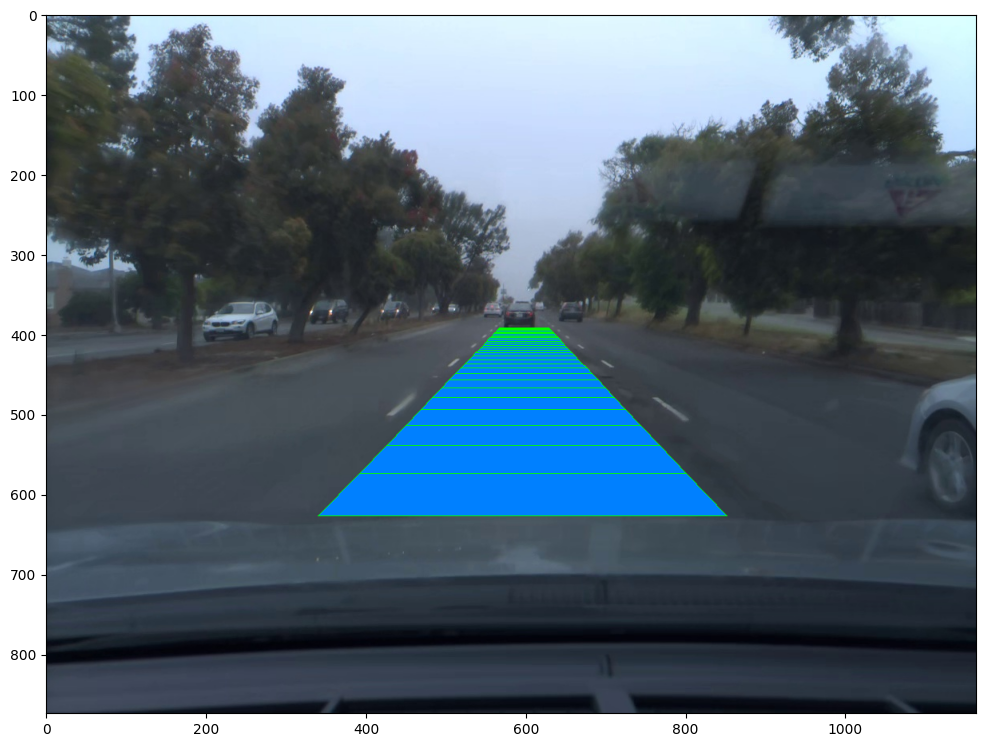

In [4]:
img = draw_debug_frame(frames, route_path, index=500, duration=30)

plt.figure(figsize=(12, 12))
plt.imshow(img)